# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.interpolate import interp1d
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import gzip
import os

Configuration

In [2]:
run_dir = Path('../prod-runs/450-nodes/')
local_ranks_per_task = {
    "run_molecular_dynamics": 8,
    "run_generator": 4, 
    "train_generator": 1
}

In [3]:
Path('figures').mkdir(exist_ok=True)

## Load in all results
Get them from each "-results.json" file

In [4]:
result_files = list(run_dir.glob('*-results.json'))
print(f'Found {len(result_files)} types of result files')

Found 4 types of result files


Store the create time, start time and end time for running, and node on which they were running

In [5]:
tasks = []
for result_file in result_files:
    task_type = result_file.name.split("-")[0]
    with open(result_file) as fp:
        for line in fp:
            row = json.loads(line)
            tasks.append({
                'task_type': task_type,
                'method': row['method'],
                'create_time': row['timestamp']['created'],
                'start_time': row['timestamp']['compute_started'],
                'end_time': row['timestamp']['compute_ended'],
                'span_running': row['time']['running'],
                'node': row['worker_info']['hostname'],
                'local_rank': int(row['worker_info']['PARSL_WORKER_RANK'])
            })
tasks = pd.DataFrame(tasks)

In [6]:
print(tasks.groupby('method')['span_running'].count().to_csv())

method,span_running
assemble_many,6393
compute_partial_charges,297
process_ligands,38685
run_GCMC_single,225
run_generator,4778
run_molecular_dynamics,123702
run_optimization,305
train_generator,85



Normalize times by the time the first task was created

In [7]:
zero_time = tasks['create_time'].min()

In [8]:
time_cols = [c for c in tasks.columns if c.endswith('time')]
tasks[time_cols] -= zero_time

Assign node ids by the first time they received a task

In [9]:
node_names = []
compute = json.loads((run_dir / 'compute-config.json').read_text())
for k, v in compute.items():
    if k.endswith('_hosts'):
        node_names.extend([
            x.split(".")[0] for x in v
        ])
num_nodes = len(node_names)
print(f'Found {len(node_names)} nodes')

Found 450 nodes


In [10]:
tasks['node_id'] = tasks['node'].apply(node_names.index)

Assign a numerical task ID

In [11]:
methods = sorted(set(tasks['method']))
tasks['task_id'] = tasks['method'].apply(methods.index)

In [12]:
methods

['assemble_many',
 'compute_partial_charges',
 'process_ligands',
 'run_GCMC_single',
 'run_generator',
 'run_molecular_dynamics',
 'run_optimization',
 'train_generator']

Get the node names for the CP2K workers

In [13]:
cp2k_workers: list[list[int]] = []
for path in sorted(run_dir.joinpath('cp2k-hostfiles').glob('local_hostfile*')):
    cp2k_workers.append([
        node_names.index(x.split(".")[0]) for x in path.read_text().split("\n")
    ])

## Plot Assignment to Different Nodes
See how work is distributed.  [color pallete](https://coolors.co/f2545b-a93f55-0f7173-75f4f4-f9c22e)

In [14]:
color_map = [
    'black', # Unknown
    'white', # Helper task
    'white', # Helper task
    'white', # Helper task
    'white', # Helper task
    '#F2545B', # Generation
    '#75F4F4', # Molecular Dynamics
    'purple', # CP2K
    'gold',  # Training
]

Prepare to store a map of node id to task type

In [15]:
task_types = [0] * len(node_names)

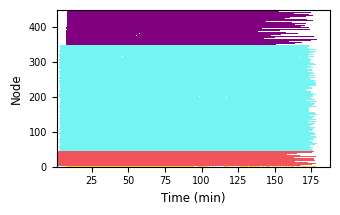

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.25))

for gid, group in tasks.groupby('method'):
    # Determine which nodes are covered
    if gid in ['process_ligands', 'compute_partial_charges', 'run_GCMC_single', 'assemble_many']:
        continue
    elif gid in ['run_optimization']:
        y = [min(cp2k_workers[l]) for l in group['local_rank']]
        height = 2
        nodes = [i + j for j in range(height) for i in set(y)]
    else:
        num_ranks = local_ranks_per_task[gid]
        height = 1 / num_ranks
        offset = group['local_rank'] / num_ranks
        y = group["node_id"] + offset
        nodes = group["node_id"]

    task_type = group["task_type"].iloc[0]
    c = color_map[methods.index(gid) + 1]
    ax.barh(y=y,
            width=group["span_running"] / 60,
            left=group["start_time"] / 60,
            height=height,
            label=gid,
            color=c,
            align='edge')
            #edgecolor='k', linewidth=0.2,)

    for i in set(nodes):
        task_types[int(i)] = methods.index(gid) + 1
    
    
#ax.set_yticks(np.arange(len(node_names)))
ax.set_ylabel('Node')

#ax.set_xlim([2, 4])
ax.set_ylim(0, num_nodes)
ax.set_xlabel('Time (min)')
#ax.legend(fontsize=8)
fig.tight_layout()
fig.savefig('figures/task-type-by-node.png', dpi=320)

## Summarize the GPU Utilization
Plot the amount of each GPU being used over time. Still color by task

In [17]:
time_offset_from_UTC = (datetime.now() - datetime.utcnow()).total_seconds() / 3600.0
time_offset_from_UTC

utilization = []
for utilization_file in tqdm(run_dir.glob('logs/*.log')):
    # Pull in the total data
    util_data = pd.read_json(utilization_file, lines=True)
    util_data['time'] = util_data['time'].apply(lambda x: datetime.fromisoformat(x).timestamp()) - zero_time + time_offset_from_UTC * 3600  # TZ Issue?
    node_name = utilization_file.name[:-4]
    util_data['node'] = node_name
    
    # Summarize the GPU utilization
    util_data['gpu_power'] = util_data['gpu_use'].apply(lambda row: [x['power.draw'] for x in row])
    util_data['gpu_mem'] = util_data['gpu_use'].apply(lambda row: [x['memory.used'] for x in row])
    util_data['gpu_use'] = util_data['gpu_use'].apply(lambda row: [x['utilization.gpu'] for x in row])
    
    utilization.append(util_data[['time', 'node', 'cpu_use', 'gpu_mem', 'gpu_power', 'gpu_use']])
utilization = pd.concat(utilization, ignore_index=True)

450it [01:25,  5.24it/s]


In [18]:
for c in ['cpu', 'gpu']:
    utilization[f'{c}_use_total'] = utilization[f'{c}_use'].apply(np.sum)
utilization['gpu_power_total'] = utilization['gpu_power'].apply(np.sum)

Compile to a full-system utilization

In [19]:
freq = 60  # How often to assess utilization

In [20]:
times = np.arange(0, utilization['time'].max(), step=freq)
system_average = {
    'time': times,
    'cpu_use': np.zeros_like(times),
    'gpu_use': np.zeros_like(times),
    'gpu_power': np.zeros_like(times),
}

In [21]:
for nid, group in utilization.groupby('node'):
    util_f = interp1d(group['time'], group['gpu_use_total'], fill_value=0, bounds_error=False)
    power_f = interp1d(group['time'], group['gpu_power_total'], fill_value=0, bounds_error=False)
    system_average['gpu_power'] += power_f(system_average['time'])
    system_average['gpu_use'] += util_f(system_average['time']) / 100  # From percentage to total

    util_f = interp1d(group['time'], group['cpu_use_total'], fill_value=0, bounds_error=False)
    system_average['cpu_use'] += util_f(system_average['time']) / 6400  # From percentage to total

In [22]:
system_average = pd.DataFrame(system_average)

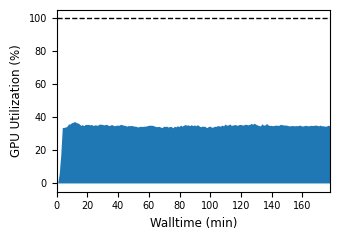

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.fill_between(system_average['time'] / 60, system_average['gpu_use'] / (num_nodes * 4) * 100)

ax.set_xlim([0, system_average['time'].max() / 60])
ax.plot(ax.get_xlim(), [100] * 2, 'k--', lw=1.)

ax.set_xlabel('Walltime (min)')
ax.set_ylabel('GPU Utilization (%)')
fig.tight_layout()
fig.savefig('figures/gpu-utilization.png', dpi=320)

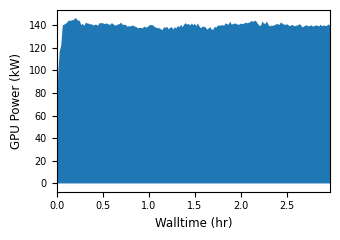

In [24]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.fill_between(system_average['time'] / 3600, system_average['gpu_power'] / 1000)

ax.set_xlim([0, system_average['time'].max() / 3600])

ax.set_xlabel('Walltime (hr)')
ax.set_ylabel('GPU Power (kW)')
fig.tight_layout()
fig.savefig('figures/gpu-utilization.png', dpi=320)

Compute node ids so we can associate nodes with tasks

In [25]:
utilization['node_id'] = utilization['node'].apply(node_names.index)

Summarize task and utilization

In [26]:
utilization_matrix = np.ones((num_nodes * 4, len(times), 4))  # Time interval, GPU ID, (RGBA) where RGB are defined by task and A by color

In [27]:
chosen_rgb = np.array([colors.to_rgb(c) for c in color_map])
for node_id, group in utilization.groupby('node_id'):
    # Get the color to use based on the task type this node is used for
    task_type = task_types[node_id]
    my_color = chosen_rgb[task_type]

    # Map the task type to color
    row_start = node_id * 4
    utilization_matrix[row_start:row_start+4, :, :3] = my_color[None, None, :]
    
    # Make the alpha channel the color
    
    for gpu_id in range(4):
        util_fun = interp1d(group['time'], group['gpu_use'].apply(lambda x: x[gpu_id] / 100), fill_value=0, bounds_error=False)
        utilization_matrix[node_id * 4 + gpu_id, :, -1] = util_fun(times)

Plot utilization.

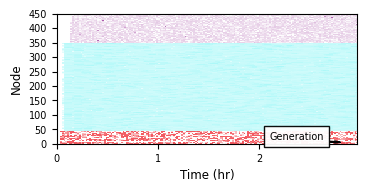

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

ax.matshow(utilization_matrix, origin='lower', aspect='auto',
           extent=[0, times.max() / 3600, 0, num_nodes])
ax.xaxis.tick_bottom()

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Node')

bbox_kwargs = dict(edgecolor='k', facecolor='w', alpha=0.95)
ax.annotate('Generation', (2.8, 5), xytext=(2.1, 15),
            bbox=bbox_kwargs, arrowprops=dict(width=0.5, headwidth=1.5, headlength=4),
           fontsize=7)
#ax.set_xlim([0, 3.])
#ax.set_ylim([9, 12])

fig.tight_layout(pad=0.1)
fig.savefig('figures/utilization-by-GPU.png', dpi=320)

## Average GPU Utilization By Task
Average GPU utilization over all nodes running different types of tasks}

In [30]:
node_type_to_task_name = {
    5: ('1 GPU', 'seagreen'),
    6: ('<1 GPU', 'tomato'),
    7: ('Multi Node', 'darkgoldenrod'),
    8: ('Single Node', 'darkorchid')
}


In [31]:
utilization['node_id'] = utilization['node'].apply(node_names.index)
utilization['node_type'] = utilization['node_id'].apply(task_types.__getitem__)

Group by Node Type

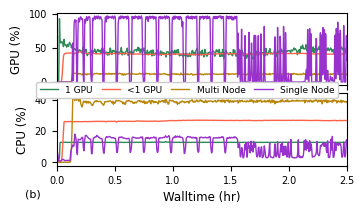

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.), sharex=True)

times = np.linspace(0, 2.5 * 3600, 1024)
axs[0].set_xlim([0, 2.5])
for node_type, group in utilization.groupby('node_type'):
    # Get the name and color used
    if node_type not in node_type_to_task_name:
        continue
    label, color = node_type_to_task_name[node_type]

    # Make interpolators over each node
    gpu_interps = []
    for nid, subgroup in group.groupby('node'):
        gpu_interps.append(
            interp1d(subgroup['time'], subgroup['gpu_use'].apply(np.mean), fill_value=0, bounds_error=False)
        )

    # Compute the average over the 3 hours of the run
    gpu_util = [
        np.mean([f(t) for f in gpu_interps])
        for t in times
    ]

    # Plot 
    axs[0].plot(times / 3600, gpu_util, color=color, label=label, lw=1)
    axs[0].set_ylabel('GPU (%)')

    # Do the same for CPU
    cpu_interps = []
    for nid, subgroup in group.groupby('node'):
        cpu_interps.append(
            interp1d(subgroup['time'], subgroup['cpu_use'].apply(lambda x: np.sum(x) / 32), fill_value=0, bounds_error=False)
        )
    cpu_util = [
        np.mean([f(t) for f in cpu_interps])
        for t in times
    ]
    axs[1].plot(times / 3600, cpu_util, color=color, label=label, lw=1)
    axs[1].set_ylabel('CPU (%)')

fig.legend(*axs[0].get_legend_handles_labels(),
          ncol=4, loc=[0.1, 0.54], fontsize=6.5, columnspacing=1, framealpha=1)
axs[1].set_xlabel('Walltime (hr)')
fig.text(0.05, 0.05, '(b)', fontsize=8)

fig.tight_layout(pad=0.2)
fig.savefig('figures/node-utilization-by-task.png', dpi=320)
fig.savefig('figures/node-utilization-by-task.pdf')